In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import gym
import matplotlib.pyplot as plt

In [ ]:
class PPOMemory:
  def __init__(self, batch_size):
    self.states = []
    self.probs = []
    self.vals = []
    self.actions = []
    self.rewards = []
    self.dones = []

    self.batch_size = batch_size

  def generate_batches(self):
    n_states = len(self.states)
    batch_start = np.arange(0, n_states, self.batch_size)
    indices = np.arange(n_states, dtype=np.int64)
    np.random.shuffle(indices)
    batches = [indices[i:i+self.batch_size] for i in batch_start]

    return np.array(self.states), np.array(self.actions), np.array(self.probs), np.array(self.vals), np.array(self.rewards), np.array(self.dones), batches

  def store_memory(self, state, action, probs, vals, reward, done):
    self.states.append(state)
    self.actions.append(action)
    self.probs.append(probs)
    self.vals.append(vals)
    self.rewards.append(reward)
    self.dones.append(done)

  def clear_memory(self):
    self.states = []
    self.probs = []
    self.actions = []
    self.rewards = []
    self.dones = []
    self.vals = []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class ActorNetwork(nn.Module):
  def __init__(self, n_actions, input_dims, alpha, fc1_dims = 256, fc2_dims = 256, chkpt_dir = ''):
    super(ActorNetwork, self).__init__()

    self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
    self.actor = nn.Sequential(
        nn.Linear(*input_dims, fc1_dims),
        nn.ReLU(),
        nn.Linear(fc1_dims, fc2_dims),
        nn.ReLU(),
        nn.Linear(fc2_dims, n_actions),
        nn.Softmax(dim=-1)
    )

    self.optimizer = optim.Adam(self.parameters(), lr=alpha)
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    dist = self.actor(state)
    dist = Categorical(dist)

    return dist

  def save_checkpoint(self):
    T.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self):
    self.load_statedict(T.load(self.checkpoint_file))

In [ ]:
class CriticNetwork(nn.Module):
  def __init__(self, input_dims, alpha, fc1_dims = 256, fc2_dims = 256, chkpt_dir = ''):
    super(CriticNetwork, self).__init__()
    self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')

    self.critic = nn.Sequential(
        nn.Linear(*input_dims, fc1_dims),
        nn.ReLU(),
        nn.Linear(fc1_dims, fc2_dims),
        nn.ReLU(),
        nn.Linear(fc2_dims, 1)

    )

    self.optimizer = optim.Adam(self.parameters(), lr=alpha)
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    value = self.critic(state)

    return value

  def save_checkpoint(self):
      T.save(self.state_dict(), self.checkpoint_file)

  def load_checkpoint(self):
    self.load_statedict(T.load(self.checkpoint_file))

In [ ]:
class Agent:
  def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda = 0.95, policy_clip=0.1, batch_size=64, N=2048, n_epochs=10):
    self.gamma = gamma
    self.policy_clip = policy_clip
    self.n_epochs = n_epochs
    self.gae_lambda = gae_lambda

    self.actor = ActorNetwork(n_actions, input_dims, alpha)
    self.critic = CriticNetwork(input_dims, alpha)
    self.memory = PPOMemory(batch_size)

  def remember(self, state, action, probs, vals, reward, done):
    self.memory.store_memory(state, action, probs, vals, reward, done)

  def save_models(self):
    print('....saving models....')
    self.actor.save_checkpoint()
    self.critic.save_checkpoint()

  def load_models(self):
    print('.....loading models.....')
    self.actor.load_checkpoint()
    self.critic.load_checkpoint()

  def choose_action(self, observation):
    state = T.tensor([observation], dtype = T.float).to(self.actor.device)

    dist = self.actor(state)
    value = self.critic(state)
    action = dist.sample()

    probs = T.squeeze(dist.log_prob(action)).item()
    action = T.squeeze(action).item()
    value = T.squeeze(value).item()

    return action, probs, value

  def learn(self):
    for _ in range(self.n_epochs):
      state_arr, action_arr, old_probs_arr, vals_arr, reward_arr, dones_arr, batches = self.memory.generate_batches()

      values = vals_arr
      advantage = np.zeros(len(reward_arr), dtype = np.float32)

      for t in range(len(reward_arr) - 1):
        discount = 1
        a_t = 0
        for k in range(t, len(reward_arr) - 1):
          a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*(1-int(dones_arr[k])) - values[k])
          discount *= self.gamma*self.gae_lambda
        advantage[t] = a_t
      advantage = T.tensor(advantage).to(self.actor.device)

      values = T.tensor(values).to(self.actor.device)

      for batch in batches:
        states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
        old_probs = T.tensor(old_probs_arr[batch]).to(self.actor.device)
        actions = T.tensor(action_arr[batch]).to(self.actor.device)

        dist =self.actor(states)
        critic_value = self.critic(states)

        critic_value = T.squeeze(critic_value)

        new_probs = dist.log_prob(actions)
        prob_ratio = new_probs.exp()/old_probs.exp()

        weighted_probs = advantage[batch] * prob_ratio
        weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]
        actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

        returns = advantage[batch] + values[batch]
        critic_loss = (returns - critic_value)**2
        critic_loss = critic_loss.mean()

        total_loss = actor_loss + 0.5*critic_loss
        self.actor.optimizer.zero_grad()
        self.critic.optimizer.zero_grad()
        total_loss.backward()
        self.actor.optimizer.step()
        self.critic.optimizer.step()

    self.memory.clear_memory()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


....saving models....
episode 0 score 35.0 avg score 35.0 time_steps 35 learning steps 1
episode 1 score 24.0 avg score 29.5 time_steps 59 learning steps 2
episode 2 score 28.0 avg score 29.0 time_steps 87 learning steps 4
episode 3 score 20.0 avg score 26.8 time_steps 107 learning steps 5
episode 4 score 65.0 avg score 34.4 time_steps 172 learning steps 8
....saving models....
episode 5 score 53.0 avg score 37.5 time_steps 225 learning steps 11
episode 6 score 35.0 avg score 37.1 time_steps 260 learning steps 13
episode 7 score 17.0 avg score 34.6 time_steps 277 learning steps 13
episode 8 score 29.0 avg score 34.0 time_steps 306 learning steps 15
episode 9 score 19.0 avg score 32.5 time_steps 325 learning steps 16
episode 10 score 62.0 avg score 35.2 time_steps 387 learning steps 19
episode 11 score 27.0 avg score 34.5 time_steps 414 learning steps 20
episode 12 score 44.0 avg score 35.2 time_steps 458 learning steps 22
episode 13 score 53.0 avg score 36.5 time_steps 511 learning ste

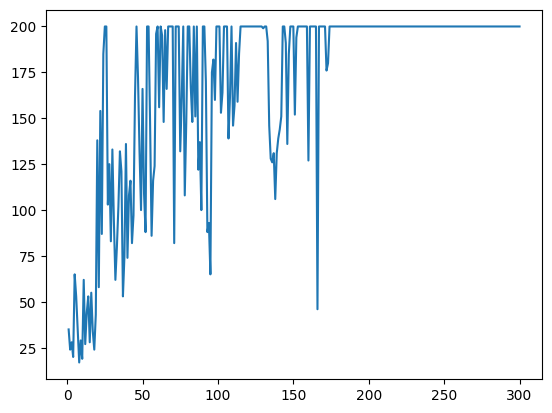

In [ ]:
if __name__ == '__main__':
  env = gym.make('CartPole-v0')
  N = 20
  batch_size = 5
  n_epochs = 4
  alpha = 0.0003
  agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, alpha=alpha, n_epochs=n_epochs, input_dims=env.observation_space.shape)

  n_games = 300

  best_score = env.reward_range[0]
  score_history = []

  learn_iters = 0
  avg_score = 0
  n_steps = 0

  for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
      action, prob, val = agent.choose_action(observation)
      observation_, reward, done, infor = env.step(action)
      n_steps += 1
      score += reward
      agent.remember(observation, action, prob, val, reward, done)
      if n_steps%N == 0:
        agent.learn()
        learn_iters += 1
      observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
      best_score = avg_score
      agent.save_models()

    print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score, 'time_steps', n_steps, 'learning steps', learn_iters)

  x = [i+1 for i in range(len(score_history))]
  plt.plot(x, score_history)